In [1]:
#imports

import h5py
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from scipy.spatial import distance_matrix

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
import glob
import matplotlib.cm as cm
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.Dark2.colors)
from TrackReconstruction_functions import *

In [2]:
#-----GET VERTEX------
def get_vertex(file_, eid):
    part = pd.read_hdf(file_, 'MC/particles')

    x_vertex = part[(part.event_id == eid) & (part.particle_id == 1)].initial_x.iloc[0]
    y_vertex = part[(part.event_id == eid) & (part.particle_id == 1)].initial_y.iloc[0]
    z_vertex = part[(part.event_id == eid) & (part.particle_id == 1)].initial_z.iloc[0]

    return x_vertex, y_vertex, z_vertex

In [3]:
#-----GET Z-SHIFT-----
def get_zshift(pressure):
    density = 5.987*pressure
    M = 1000/0.9
    det_size = 1000*np.cbrt((4 * M) / (np.pi * density))/2.0

    return det_size

In [4]:
#example file

file = "/home/rei/NEXT/vertex_ML/diffused_data/0nubb/5bar/5percent/ATPC_0nubb_5bar_Efilt_5.0percent_smear_20_4.h5"
hits_df = pd.read_hdf(file, "MC/hits")
parts_df = pd.read_hdf(file, "MC/particles")
pressure= 5
diffusion = "5percent"
eid = 1848
data = hits_df[hits_df["event_id"] == eid].copy()


Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_size  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is:",           voxel_size)
print("The det_size is", det_size)

# energy_threshold = 0.0004

mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())

# The expected diffusion is less than vox size so replace
if (mean_sigma < 1.5*voxel_size):
    mean_sigma = 1.5*voxel_size


if (diffusion == "next1t"):
    mean_sigma=6
elif (diffusion == "nodiff"):
    mean_sigma=10/np.sqrt(pressure)

print("Mean sigma", mean_sigma)

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  0.14042506898698678 mm/sqrt(cm)
Energy threshold is:  0.3 keV
diffision scale factor is:  6
Radius scale factor is:  7
Hit grouping factor is:  1
Tortuosity distance scale is: 70.0
The voxel size is: 3
The det_size is 1807.7267582900142
Mean sigma 9.847070924698887


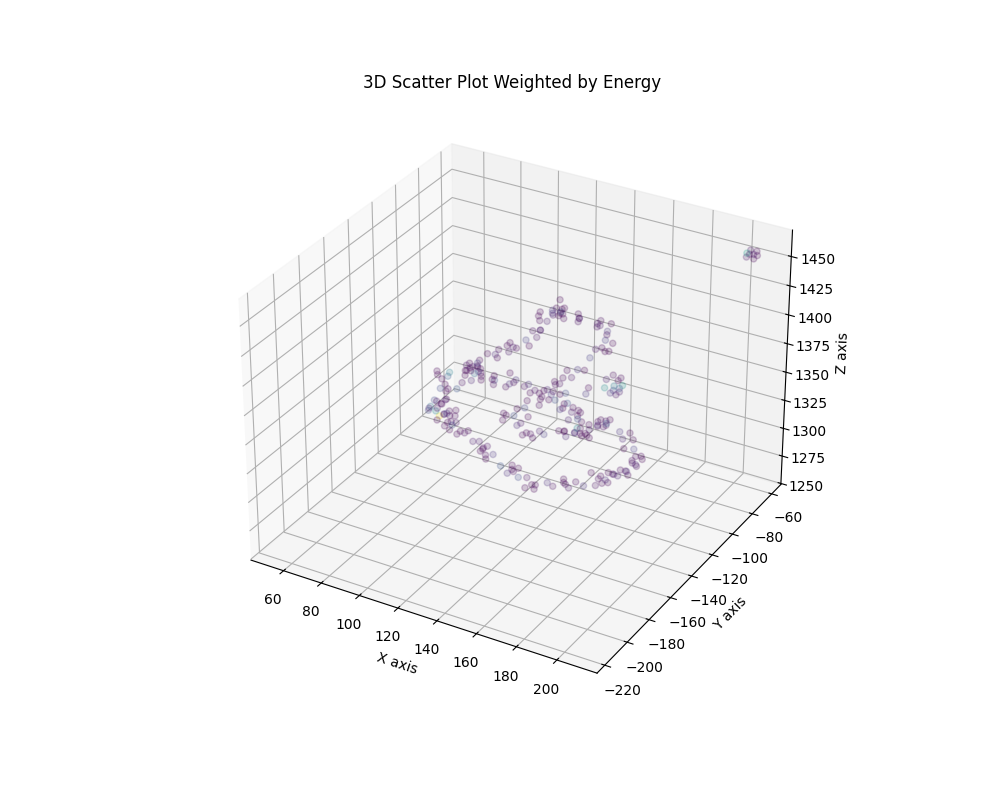

In [5]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.2)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [6]:
print(data.energy.sum())

# If there are overlapping voxels, merge them. Otherwise the energy gets messed up
data = (data.groupby(["event_id", "x", "y", "z"], as_index=False)["energy"].sum())

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

print(data.energy.sum())
display(data)

2.4473383
2.447338


event_id           x          y            z    energy
0        1848   53.805431 -90.863029  1273.053589  0.047591
1        1848   54.503448 -88.408806  1277.143188  0.029165
2        1848   54.917324 -94.556595  1273.121826  0.028520
3        1848   55.741604 -95.339294  1276.181152  0.012053
4        1848   55.765640 -80.552200  1285.626221  0.000050
..        ...         ...        ...          ...       ...
268      1848  204.952667 -61.893154  1457.753662  0.007812
269      1848  208.034988 -65.166855  1457.928345  0.007762
270      1848  208.036438 -61.917809  1458.098022  0.001017
271      1848  208.155045 -65.253067  1454.275269  0.000397
272      1848  208.355743 -62.010918  1454.729858  0.000074

[273 rows x 5 columns]

Mean z: 1365.9108  diffusion =  9.847070924698887
Mean Sigma:  9.847070924698887
Mean sigma group 1.6411784874498148
Running grouping again new mean sigma is: 3.2823569748996295
Running grouping again new mean sigma is: 6.564713949799259
Running grouping again new mean sigma is: 13.129427899598518


/home/rei/NEXT/vertex_ML/scripts/TrackReconstruction_functions.py:710: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["energy"] += cut_data["energy"] / cut_data["energy"].sum() * removed_energy


x           y            z    energy  group_id
0    58.959751  -93.672279  1273.737549  0.352923         0
1    60.894497  -78.080170  1282.495972  0.040902         0
2    64.341171  -67.943176  1287.672729  0.058879         0
3    67.612175  -94.659462  1269.769897  0.005396         0
4    65.824654  -71.569557  1298.866943  0.018549         0
5    71.817886  -76.466537  1302.024780  0.022875         0
6    85.854973  -79.901558  1301.816284  0.047640         0
7    98.389091  -80.939621  1308.058594  0.043537         0
8   108.873024  -79.823311  1305.448364  0.021657         0
9   112.434952 -170.768555  1394.586792  0.128847         0
10  118.417999  -79.298294  1300.632446  0.054627         0
11  118.093216 -184.977234  1381.726685  0.029141         0
12  119.311409 -158.414246  1399.063843  0.030334         0
13  125.165398  -82.929611  1292.477539  0.022825         0
14  124.042175 -184.104614  1370.152222  0.044706         0
15  127.184494 -147.638779  1404.001099  0.032647         0
16  131.757019  -87.815819  1288.565552  0.065045         0
17  134.146667 -139.658569  1410.545654  0.024740         0
18  135.383179 -182.304367  1359.276489  0.026232         0
19  138.769974  -89.381790  1292.787231  0.010791         0
20  138.727631 -134.603790  1418.379272  0.034710         0
21  140.590302 -179.465912  1349.852417  0.019767         0
22  143.154633 -131.048325  1430.313110  0.027351         0
23  144.422760 -176.858185  1337.535156  0.052812         0
24  145.257462  -90.481812  1300.539185  0.037247         0
25  149.374222 -137.461563  1440.178345  0.058506         0
26  150.938828  -95.246796  1309.426147  0.045651         0
27  151.797546 -174.544754  1331.046631  0.036177         0
28  161.160675 -140.740082  1442.896240  0.021135         0
29  162.522278 -101.777367  1310.219360  0.031379         0
30  163.315857 -168.233978  1326.397949  0.023671         0
31  169.247269 -142.988327  1443.169800  0.015963         0
32  174.049362 -213.427933  1423.189453  0.064622         0
33  174.167938 -208.620590  1431.086426  0.028743         0
34  174.052551 -159.317963  1321.757202  0.031453         0
35  173.821289 -110.218025  1306.848267  0.035233         0
36  178.306885 -147.935699  1447.196167  0.032920         0
37  180.061661 -194.896194  1431.520508  0.046695         0
38  180.137817 -176.970551  1436.674561  0.026331         0
39  178.771591 -144.392853  1318.246582  0.031304         0
40  178.857773 -130.604858  1310.213745  0.032125         0
41  179.200089 -118.815262  1307.098389  0.011313         0
42  182.546173 -208.963730  1413.205688  0.023323         0
43  182.508377 -166.917236  1442.934448  0.033318         0
44  184.908310 -190.573578  1428.271118  0.072604         0
45  183.759018 -157.314774  1448.024170  0.023124         0
46  196.825974 -172.798553  1427.897095  0.283328         0
47  195.549316 -174.653458  1436.253418  0.015863         0
48  191.964813 -201.862274  1412.139038  0.034313         0
49  191.858246 -195.753906  1419.497192  0.035183         0
50  205.057175  -64.922020  1457.452026  0.098885         1

51 2.4473384018056095


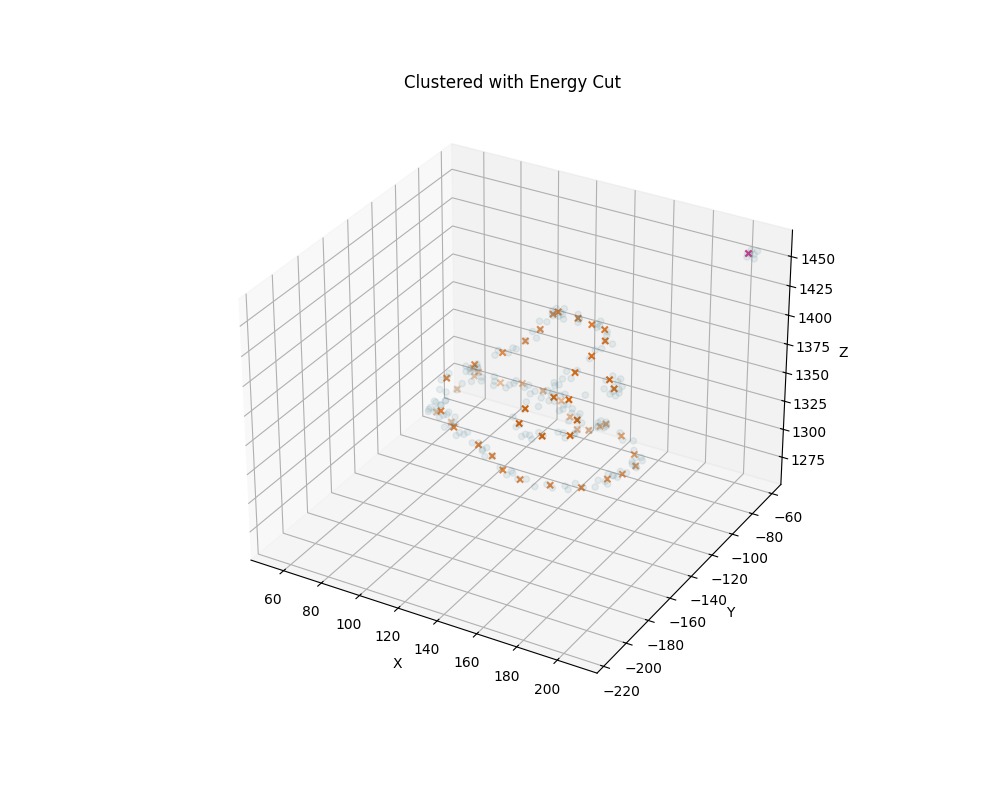

In [7]:
# display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)

# Apply grouping
data_copy = data.copy()

df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

if (mean_sigma_group < voxel_size/2.0):
    mean_sigma_group = voxel_size/2.0

if diffusion == "next1t":
    mean_sigma_group = 10
# elif (diffusion == "nodiff"):
#     mean_sigma_group=15
print("Mean sigma group", mean_sigma_group)

df_merged = GroupHits(df_merged, mean_sigma_group)

# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Unclustered
# for gid in sorted(df_merged.group_id.unique()):
#     # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
#     # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
#     temp_df = df_merged[df_merged.group_id == gid]
#     ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

# Clustered
for gid in sorted(node_centers_df.group_id.unique()):
    ax.scatter(df_merged['x'], df_merged['y'], df_merged['z'], marker='o',alpha=0.05)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = node_centers_df[node_centers_df.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Clustered with Energy Cut')
plt.show()



In [22]:
def get_node_centers_df(hits_df, eid, pressure, diffusion):
    data = hits_df[hits_df["event_id"] == int(eid)].copy()
    print("1:",len(data))
    if np.isnan(data.z.mean()) or data.z.empty:
        print(f"Skipping event {eid} because hits are missing or invalid")
        return pd.DataFrame()
    #print(pressure, type(pressure))
    #print(diffusion, type(diffusion))
    Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_size  = InitializeParams(pressure, diffusion)
    # voxel_sf=1.1
    # energy_threshold=0
    # energy_threshold = 0.0004
    #print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
    #print("Energy threshold is: ",        1000*energy_threshold, "keV")
    #print("diffision scale factor is: ",  diff_scale_factor)
    #print("Radius scale factor is: ",     radius_sf)
    #print("Hit grouping factor is: ",     group_sf)
    #print("Tortuosity distance scale is:", Tortuosity_dist)
    #print("The voxel size is:",           voxel_size)
    #print("The det_size is", det_size)

    
    mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())
    
    # The expected diffusion is less than vox size so replace
    if (mean_sigma < 1.5*voxel_size):
        mean_sigma = 1.5*voxel_size
    
    
    if (diffusion == "next1t"):
        mean_sigma=6
    elif (diffusion == "nodiff"):
        mean_sigma=10/np.sqrt(pressure)
    
    # Create the bins ---- 
    xbw  = mean_sigma
    xmin = -det_size - mean_sigma/2 
    xmax = det_size  + mean_sigma/2
    
    ybw  = mean_sigma
    ymin = -det_size - mean_sigma/2 
    ymax = det_size  + mean_sigma/2
    
    # This shifts the z pos of the events so 0 is at anode
    # can set this to zero
    z_shift = det_size
    # z_shift = 0
    
    zbw=mean_sigma
    zmin=-det_size + z_shift - mean_sigma/2 
    zmax=det_size + z_shift + mean_sigma/2

    # bins for x, y, z
    xbins = np.arange(xmin, xmax+xbw, xbw)
    ybins = np.arange(ymin, ymax+ybw, ybw)
    zbins = np.arange(zmin, zmax+zbw, zbw)
    
    # center bins for x, y, z
    xbin_c = xbins[:-1] + xbw / 2
    ybin_c = ybins[:-1] + ybw / 2
    zbin_c = zbins[:-1] + zbw / 2

    # If there are overlapping voxels, merge them. Otherwise the energy gets messed up
    data = (data.groupby(["event_id", "x", "y", "z"], as_index=False)["energy"].sum())
    print("2:",len(data))
    # then sort it based on the x,y,z
    data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)
    print("3:",len(data))
    # Apply grouping
    data_copy = data.copy()
    print("4:",len(data_copy))
    #df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)
    
    mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())
    
    if (mean_sigma_group < voxel_size/2.0):
        mean_sigma_group = voxel_size/2.0
    
    if diffusion == "next1t":
        mean_sigma_group = 10
    # elif (diffusion == "nodiff"):
    #     mean_sigma_group=15
    #print("Mean sigma group", mean_sigma_group)
    #print("Number of hits:", len(data))
    #print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
    #print("Mean Sigma: ", mean_sigma)
    #print("Mean sigma group:", mean_sigma_group)

    
    df_merged = GroupHits(data_copy, mean_sigma_group)
    print("5:",len(df_merged))
    # Apply clustering
    node_centers_df = []
    
    for gid in sorted(df_merged.group_id.unique()):
        temp_df = df_merged[df_merged.group_id == gid]
        temp_df.reset_index(drop=True, inplace=True)
        node_centers_df.append(Cluster(temp_df, mean_sigma))
    
    node_centers_df = pd.concat(node_centers_df, ignore_index=True)
    print("6:",len(node_centers_df))
    return node_centers_df, z_shift


In [38]:
def get_e_vectors(node_centers_df, z_shift, vertex, hits_df):
  
    df = node_centers_df[node_centers_df["group_id"] == 0].copy()

    #df["z"] = df["z"] - z_shift  
    vertex = np.array(vertex, dtype=float).copy()
    vertex[2] += z_shift
    hits = df[["x", "y", "z"]].values
    
    dists = np.linalg.norm(hits - vertex, axis=1) 
    N=30 #cluster 30 hits total
    closest_hits = hits[np.argsort(dists)[:N]] # sort by dist
    hits_from_vertex = closest_hits - vertex # use vertex as reference
    radii = np.linalg.norm(hits_from_vertex, axis=1)

    # keep only hits that are not at the vertex
    mask = radii > 3
    hits_from_vertex = hits_from_vertex[mask]
    closest_hits = closest_hits[mask]
    radii = radii[mask]

    if len(radii)<2:
        #print("Not enough hits to cluster")
        return[]
        
    # normalize
    directions = hits_from_vertex / radii[:, None]
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(directions) # 2 clusters
    labels = kmeans.labels_
    
    vectors = []
    for cluster_id in [0,1]:
        cluster_hits = closest_hits[labels == cluster_id] #cluster hits
    
        if len(cluster_hits) == 0:
            #print("Not enough hits")
            continue
            
        #get vectors
        dists = np.linalg.norm(cluster_hits - vertex, axis=1)
        endpoint = cluster_hits[np.argmin(dists)]
        direction_vector = endpoint - vertex
        vectors.append((endpoint, direction_vector))

        # plot clustered hits
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection="3d")

        event_hits = hits_df[hits_df.event_id == eid].copy()
        #event_hits["z"] = event_hits["z"]-z_shift
        
        colors = ["red", "blue"]
        for cluster_id in [0, 1]:
            cluster_hits = closest_hits[labels == cluster_id]
            ax.scatter(cluster_hits[:, 0], cluster_hits[:, 1], cluster_hits[:, 2],
                       label=f"Cluster {cluster_id}", color=colors[cluster_id], s=40)

        ax.scatter(vertex[0], vertex[1], vertex[2], color="black", s=60, label="Vertex")
        ax.scatter(hits[:, 0], hits[:, 1], hits[:, 2], color="purple", s=10, alpha=0.8, label="Clustered", marker="+")
        ax.scatter(event_hits["x"], event_hits["y"], event_hits["z"],
            alpha=0.4, color="grey", label="Original hits")

        ax.legend()
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title("KMeans Clustering of Hits")

        plt.show()
    
    return vectors

In [39]:
file = "/home/rei/NEXT/vertex_ML/diffused_data/0nubb/5bar/5percent/ATPC_0nubb_5bar_Efilt_5.0percent_smear_20_4.h5"

# Load the hits group
hits_df = pd.read_hdf(file, "MC/hits")

# Print the unique event IDs
print("Unique event_ids in MC/hits:")
print(hits_df["event_id"].unique())

Unique event_ids in MC/hits:
[1848 1849 1850 1851 1852 1853 1855 1856 1857 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1875 1876 1877 1878
 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892
 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1906 1907 1908
 1909 1910 1911 1912]


In [40]:
# function to project the vectors onto XY, YZ, XZ planes
def project_vectors_kmeans(file, eid, pressure, diffusion, vertex=None):
    #load data
    hits_df = pd.read_hdf(file, "MC/hits")

    node_centers_df, z_shift = get_node_centers_df(hits_df, eid, pressure, diffusion)
    node_centers_df = node_centers_df.copy()

    #get vertex and vectors
    #if vertex == None:
    x_vertex, y_vertex, z_vertex = get_vertex(file, eid)
    vertex = np.array([x_vertex, y_vertex, z_vertex])
    #else:
        #x_vertex, y_vertex, z_vertex = vertex[0], vertex[1], vertex[2]
        
    vectors = get_e_vectors(node_centers_df, z_shift, vertex, hits_df)
    if len(vectors) < 2:
        print(f"Event {eid} skipped: not enough hits to define vectors")
        return  # skip event
    v1 = vectors[0][1]  # direction vector of first track
    v2 = vectors[1][1]  # direction vector of second track

    event_hits = hits_df[hits_df.event_id == eid].copy()
    event_hits["z"] = event_hits["z"]-z_shift

    indices = np.arange(len(event_hits))
    
    xs = [x_vertex, x_vertex + v1[0], x_vertex + v2[0]]
    ys = [y_vertex, y_vertex + v1[1], y_vertex + v2[1]]
    zs = [z_vertex, z_vertex + v1[2], z_vertex + v2[2]]


    #min/max
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)
    zmin, zmax = min(zs), max(zs)

    #ranges = and padded
    max_range = max(xmax-xmin, ymax-ymin, zmax-zmin)
    pad = 2 * max_range #20% padding

    xmid = (xmax + xmin) / 2 
    ymid = (ymax + ymin) / 2
    zmid = (zmax + zmin) / 2

    xlims = (xmid - max_range/2 - pad, xmid + max_range/2 + pad)
    ylims = (ymid - max_range/2 - pad, ymid + max_range/2 + pad)
    zlims = (zmid - max_range/2 - pad, zmid + max_range/2 + pad)

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    #XY projection
    ax1.scatter(x_vertex, y_vertex, color = "black", s=30, label="vertex")
    ax1.scatter(event_hits.x, event_hits.y, alpha=0.2, c=event_hits.energy, cmap="Greys_r")
    ax1.quiver(x_vertex, y_vertex, v1[0], v1[1], color="blue", label="e1", scale_units="xy", scale=1)
    ax1.quiver(x_vertex, y_vertex, v2[0], v2[1], color="red", label="e2", scale_units="xy", scale=1)
    ax1.set_xlim(xlims)
    ax1.set_ylim(ylims)
    ax1.set_xlabel("X", fontweight="bold")
    ax1.set_ylabel("Y", fontweight="bold")
    ax1.set_title("XY Projection")
    ax1.legend(loc="lower left")
    ax1.grid(True)
    
    #YZ projection
    ax2.scatter(y_vertex, z_vertex, color = "black", s=30, label="vertex")
    ax2.scatter(event_hits.y, event_hits.z, alpha=0.2, c=event_hits.energy, cmap="Greys_r")
    ax2.quiver(y_vertex, z_vertex, v1[1], v1[2], color="blue", label="e1", scale_units="xy", scale=1)
    ax2.quiver(y_vertex, z_vertex, v2[1], v2[2], color="red", label="e2", scale_units="xy", scale=1)
    ax2.set_xlim(ylims)
    ax2.set_ylim(zlims)
    ax2.set_xlabel("Y", fontweight="bold")
    ax2.set_ylabel("Z", fontweight="bold")
    ax2.set_title("YZ Projection")
    ax2.legend(loc="lower left")
    ax2.grid(True)

    #XZ projection
    ax3.scatter(x_vertex, z_vertex, color = "black", s=30, label="vertex")
    ax3.scatter(event_hits.x, event_hits.z, alpha=0.2, c=event_hits.energy, cmap="Greys_r")
    ax3.quiver(x_vertex, z_vertex, v1[0], v1[2], color="blue", label="e1", scale_units="xy", scale=1)
    ax3.quiver(x_vertex, z_vertex, v2[0], v2[2], color="red", label="e2", scale_units="xy", scale=1)
    ax3.set_xlim(xlims)
    ax3.set_ylim(zlims)
    ax3.set_xlabel("X", fontweight="bold")
    ax3.set_ylabel("Z", fontweight="bold")
    ax3.set_title("XZ Projection")
    ax3.legend(loc="lower left")
    ax3.grid(True)

    fig.suptitle(f"Vector Projections KMeans {eid}", fontweight="bold")

    plt.show()

In [41]:
#create 3D plot of all event hits and vertex

def PlotEvent3D(axis, file_, title, eid, part, z_shift):
    fig = plt.figure(figsize=(5.12, 5.12), dpi=100)


    hits = pd.read_hdf(file_, 'MC/hits')
    event_hits = hits[hits.event_id == eid].copy()
    event_hits["z"] = event_hits["z"]-z_shift
    part = pd.read_hdf(file_, 'MC/particles')
    part = part[(part.event_id == eid) & (part.primary == 1)]
    x_vertex, y_vertex, z_vertex = get_vertex(file_, eid)
    
    # Create 3D axes
    ax = fig.add_subplot(axis, projection='3d')

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    # Scatter plot in 3D
    sc = ax.scatter(event_hits.x, event_hits.y, event_hits.z, 
                    c=event_hits.energy, cmap='Spectral', s=10, label="Reco hits")
    
    ver = ax.scatter(x_vertex, y_vertex, z_vertex, s=50, color="black")

    ax.set_xlabel("X [mm]", fontsize=15, color='black')
    ax.set_ylabel("Y [mm]", fontsize=15, color='black')
    ax.set_zlabel("Z [mm]", fontsize=15, color='black')

    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.zaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.tick_params(axis='z', colors='black')

    ax.set_title(title, fontsize=15, color='black')

    ax.grid(False)

    # Add colorbar
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10, pad=0.09)
    cbar.set_label("Energy", fontsize=12, color='black')
    cbar.ax.yaxis.set_tick_params(color='black')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

    # Remove background panes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    plt.show(fig)

    return sc, x_vertex, y_vertex, z_vertex

Processing event 1848...
1: 273
2: 273
3: 273
4: 273
Running grouping again new mean sigma is: 3.2823569748996295
Running grouping again new mean sigma is: 6.564713949799259
Running grouping again new mean sigma is: 13.129427899598518
5: 273
6: 58


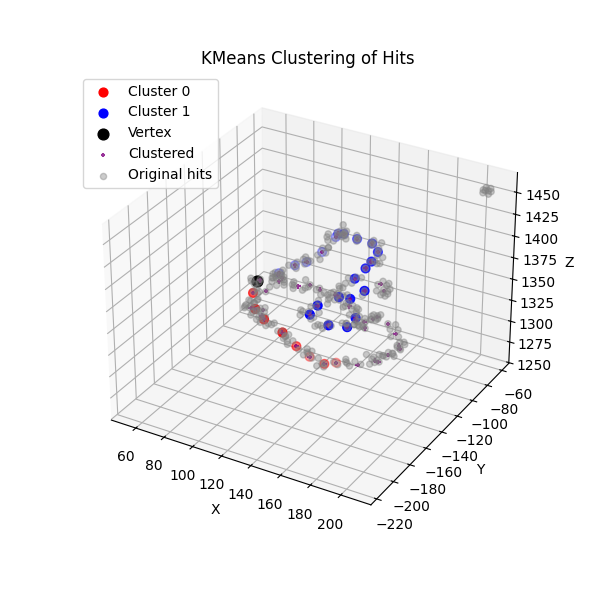

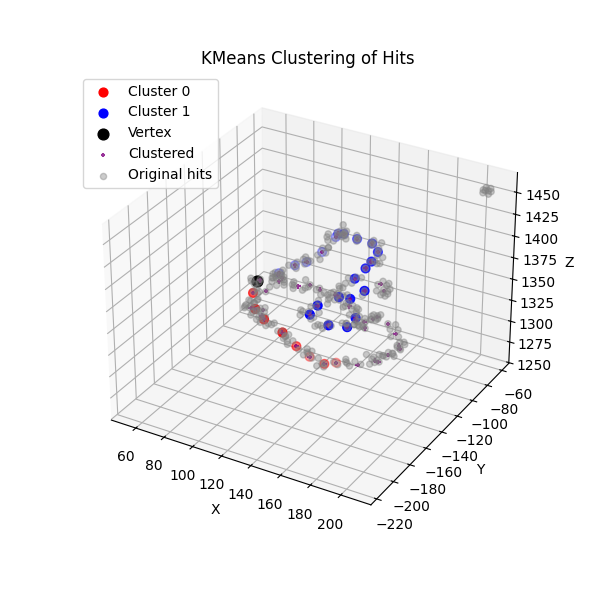

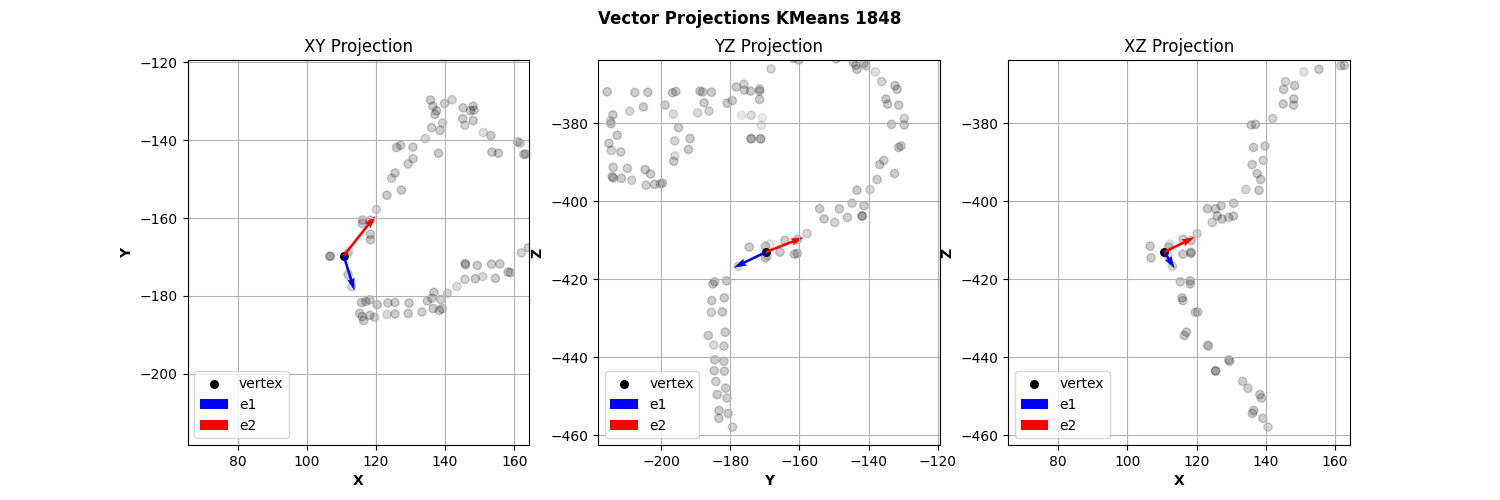

Processing event 1849...
1: 329
2: 329
3: 329
4: 329
Running grouping again new mean sigma is: 4.502033797037676
Running grouping again new mean sigma is: 9.004067594075352
5: 329
6: 55


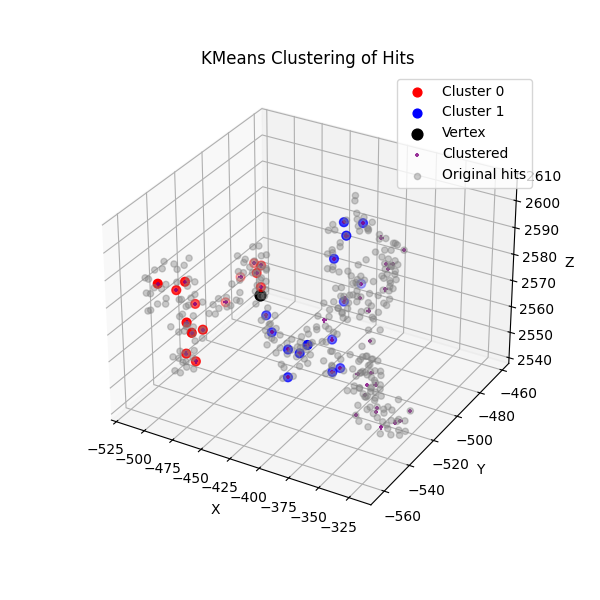

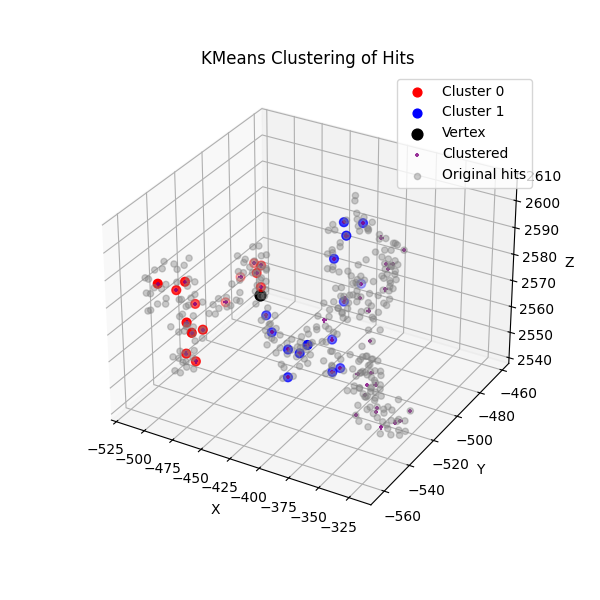

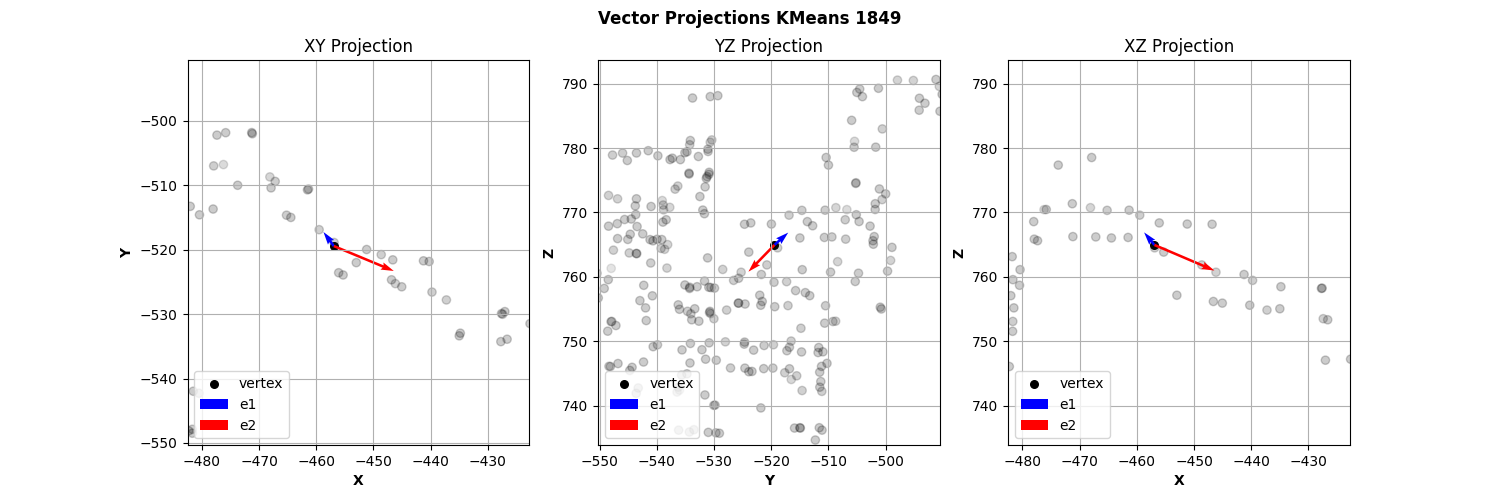

Processing event 1850...
1: 124
2: 124
3: 124
4: 124
Running grouping again new mean sigma is: 3.0
Running grouping again new mean sigma is: 6.0
Running grouping again new mean sigma is: 12.0
5: 124
6: 79


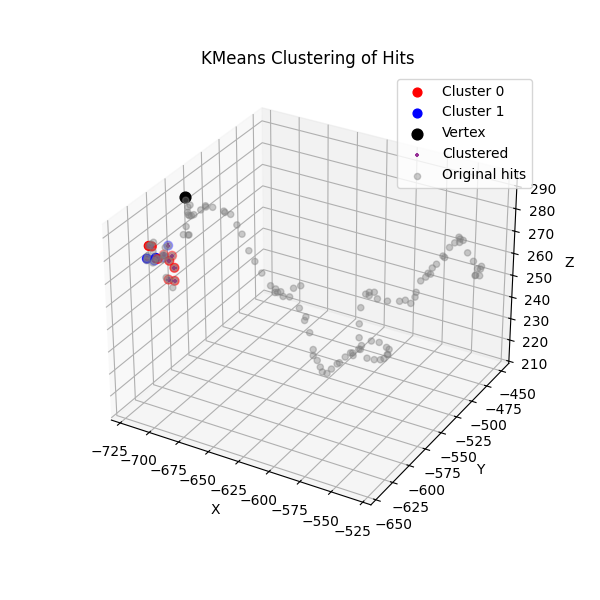

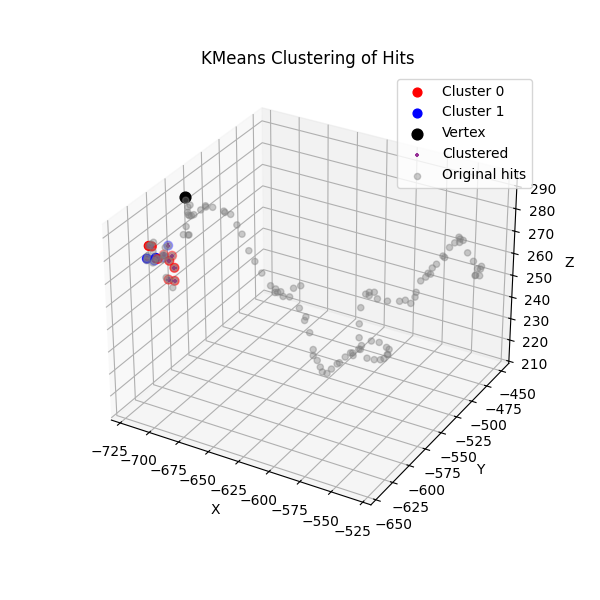

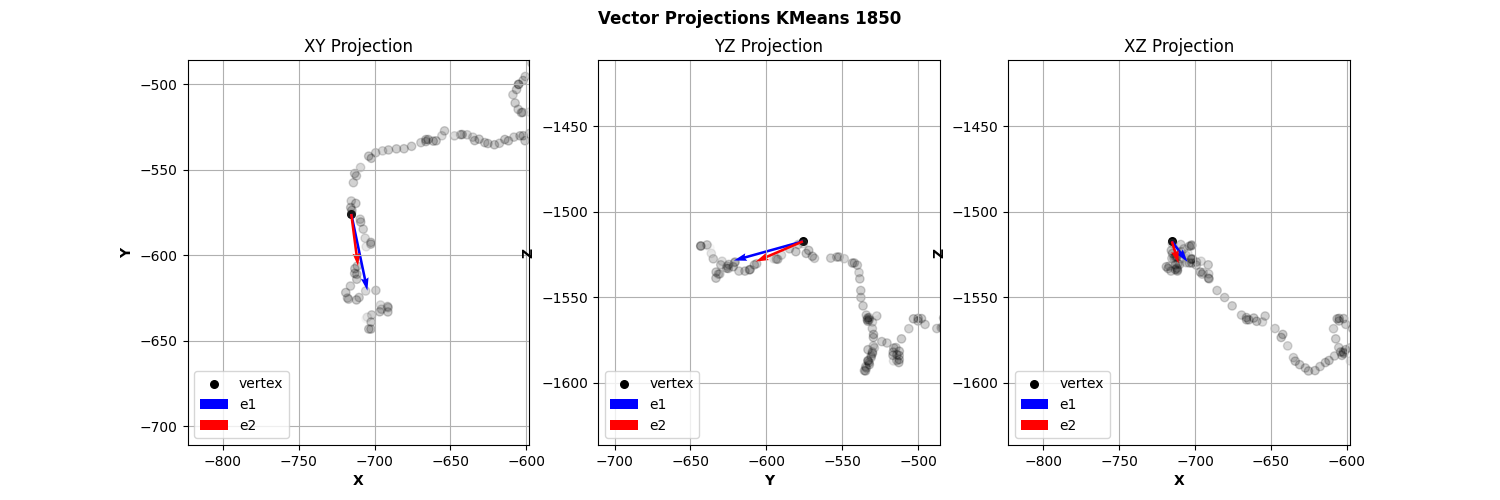

Processing event 1851...
1: 319
2: 319
3: 319
4: 319
Running grouping again new mean sigma is: 4.520506156042448
Running grouping again new mean sigma is: 9.041012312084897
5: 319
6: 49


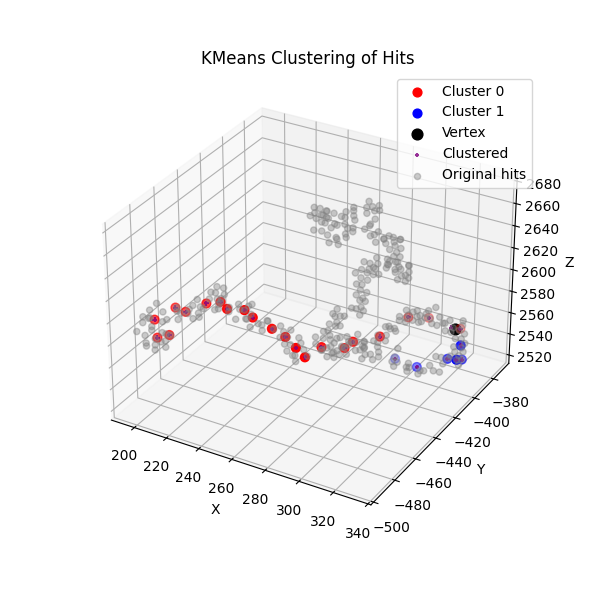

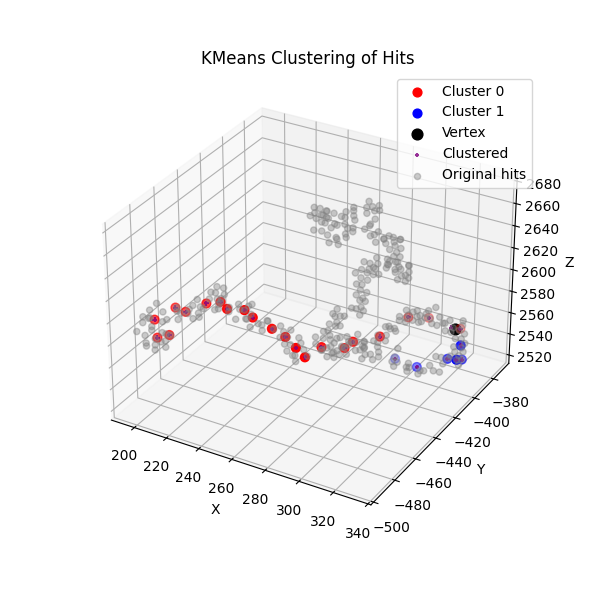

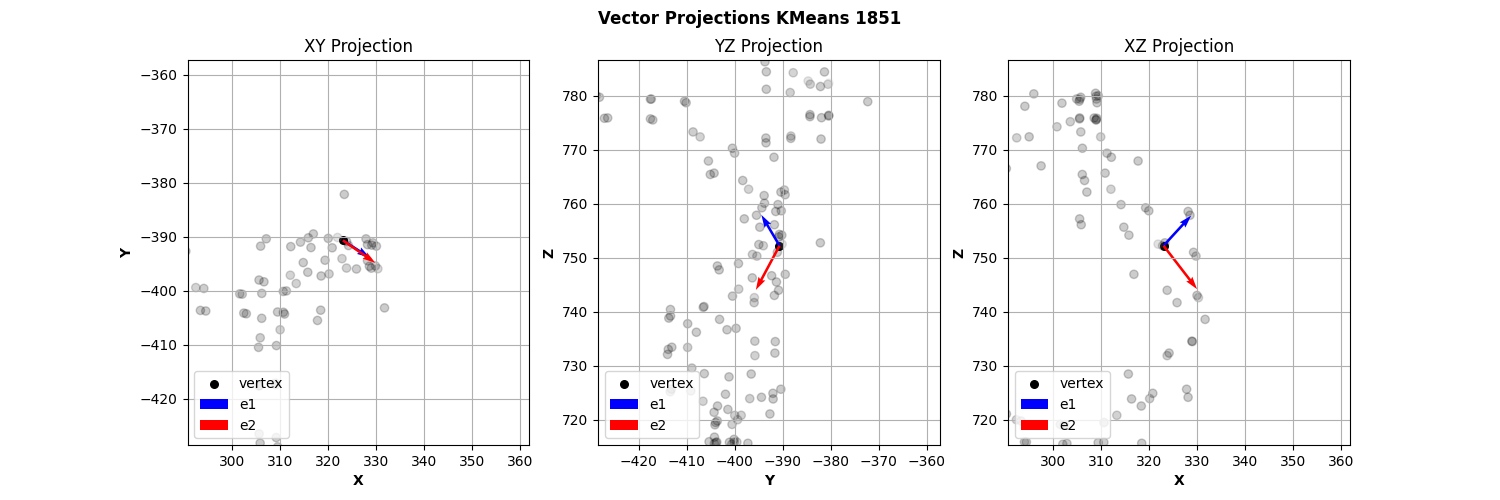

Processing event 1852...
1: 277
2: 277
3: 277
4: 277
Running grouping again new mean sigma is: 4.06069258567004
Running grouping again new mean sigma is: 8.12138517134008
Running grouping again new mean sigma is: 16.24277034268016
5: 277
6: 53


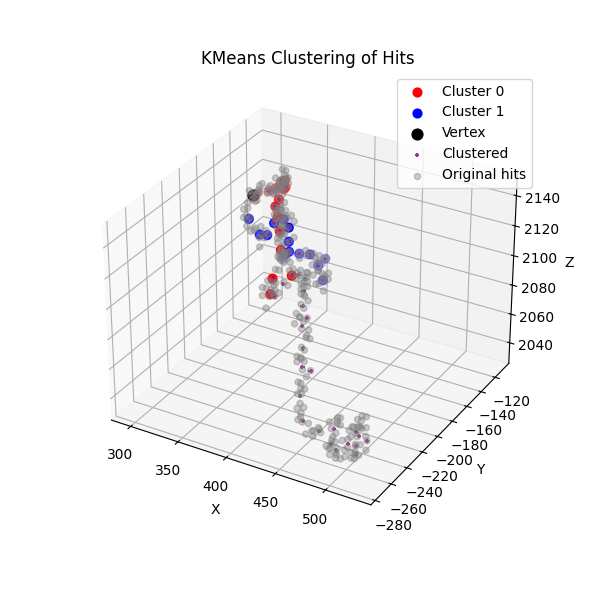

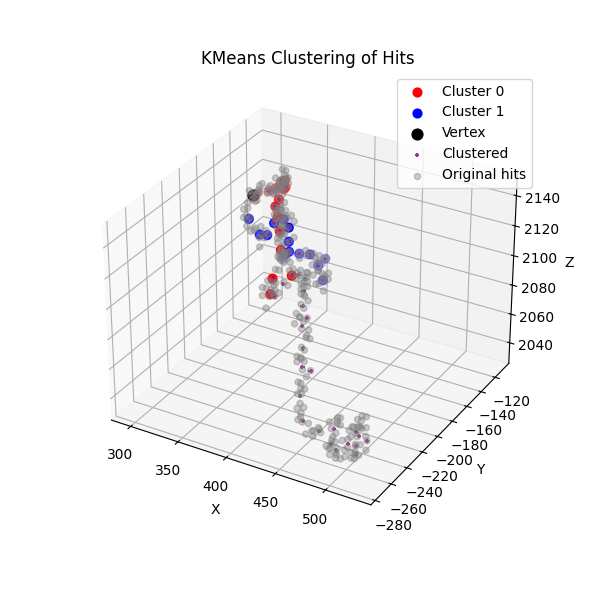

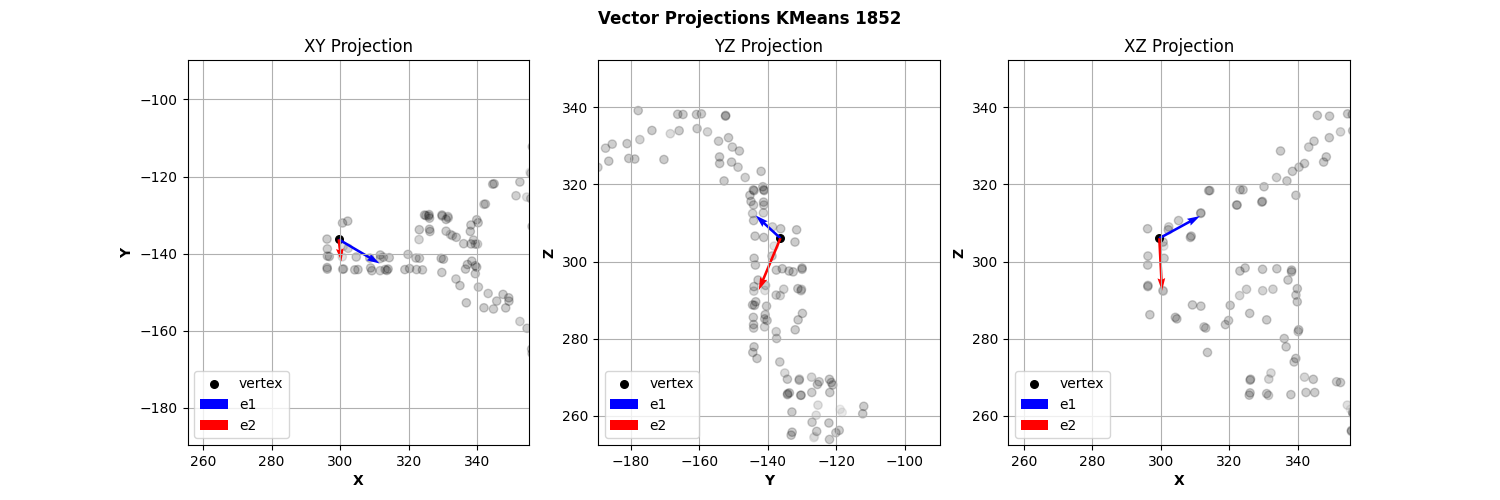

Processing event 1853...
1: 136
2: 136
3: 136
4: 136
Running grouping again new mean sigma is: 3.0
Running grouping again new mean sigma is: 6.0
Running grouping again new mean sigma is: 12.0
5: 136
6: 48
Event 1853 skipped: not enough hits to define vectors
Processing event 1855...
1: 226
2: 226
3: 226
4: 226
Running grouping again new mean sigma is: 3.817016704211399
Running grouping again new mean sigma is: 7.634033408422798
Running grouping again new mean sigma is: 15.268066816845597
5: 226
6: 44
Event 1855 skipped: not enough hits to define vectors
Processing event 1856...
1: 219
2: 219
3: 219
4: 219
Running grouping again new mean sigma is: 3.154718298827166
Running grouping again new mean sigma is: 6.309436597654332
Running grouping again new mean sigma is: 12.618873195308664
5: 219
6: 48


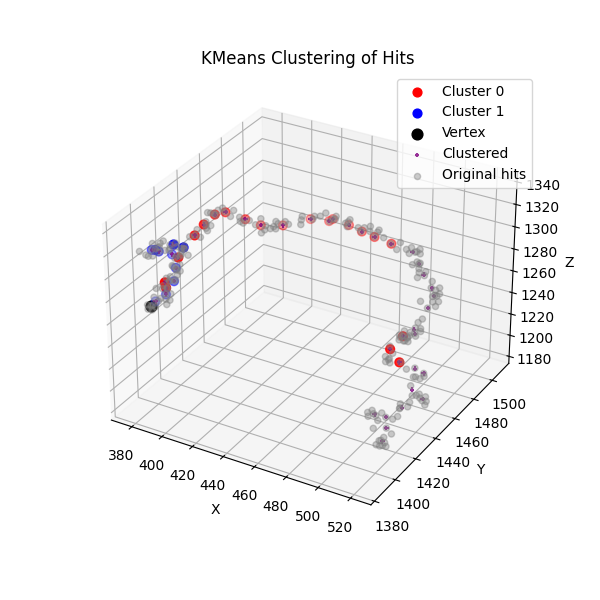

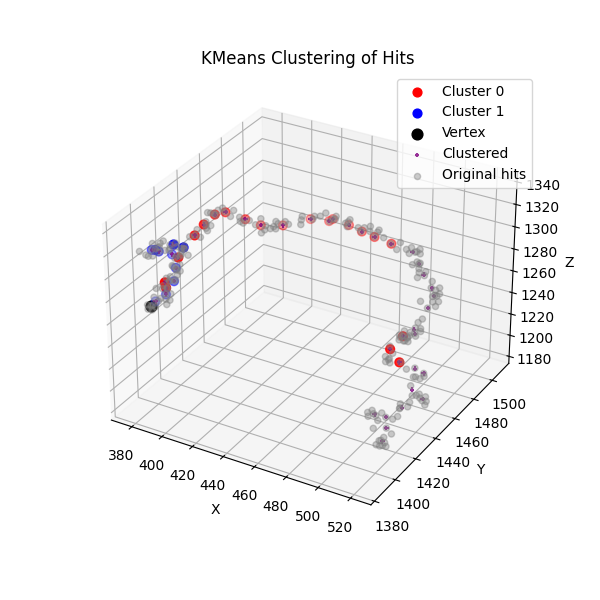

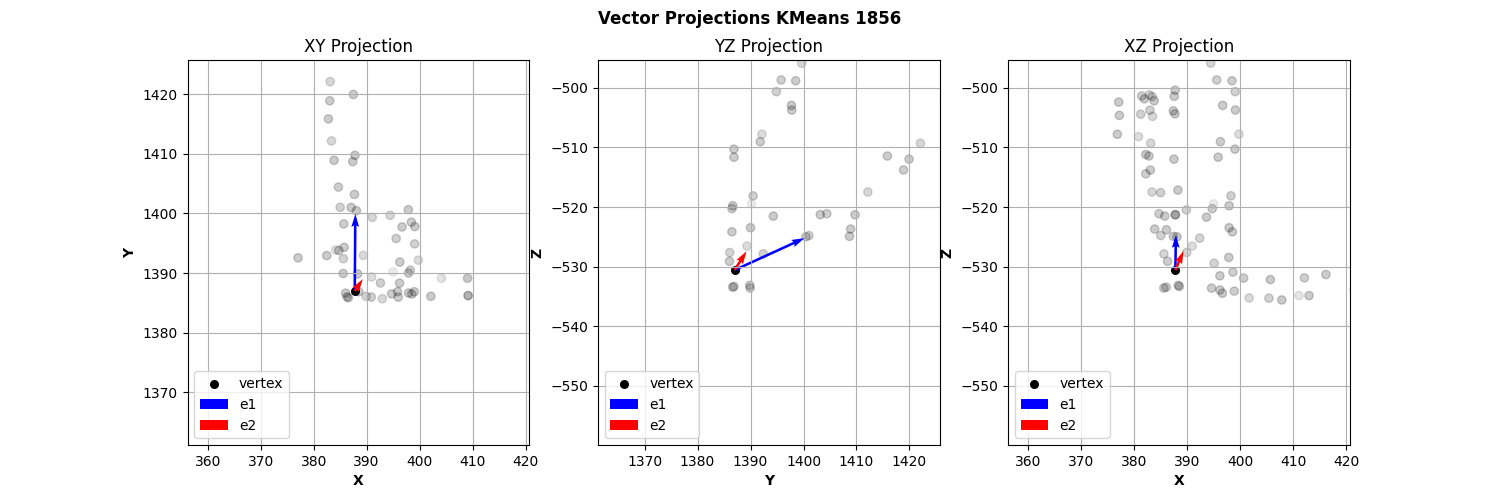

Processing event 1857...
1: 258
2: 258
3: 258
4: 258
Running grouping again new mean sigma is: 4.36995166260932
Running grouping again new mean sigma is: 8.73990332521864
5: 258
6: 44


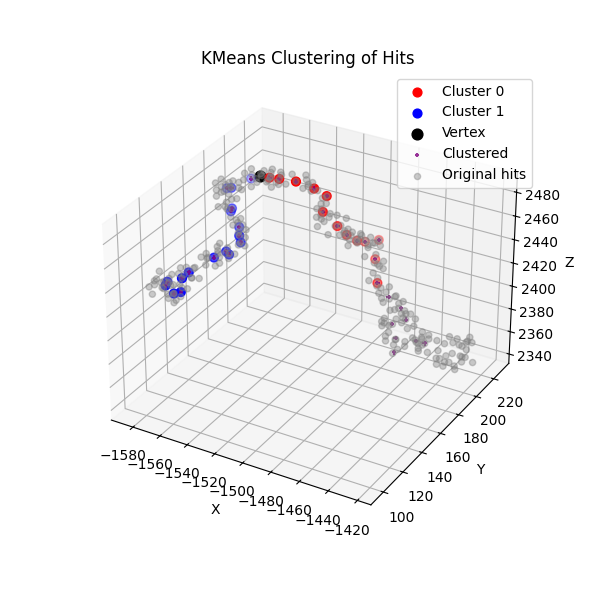

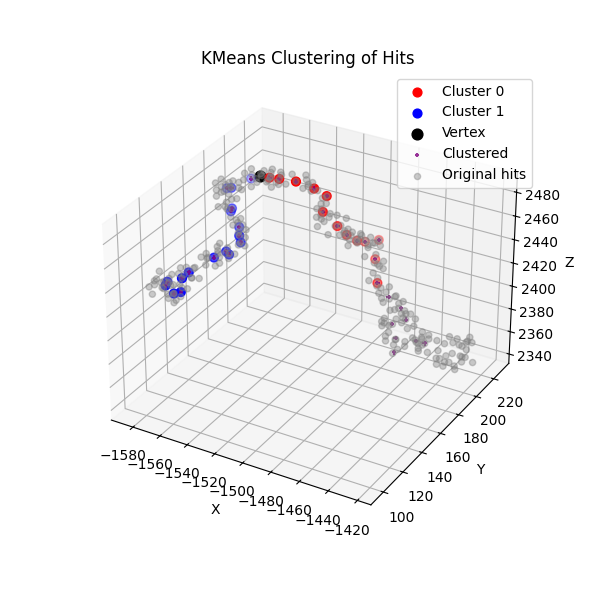

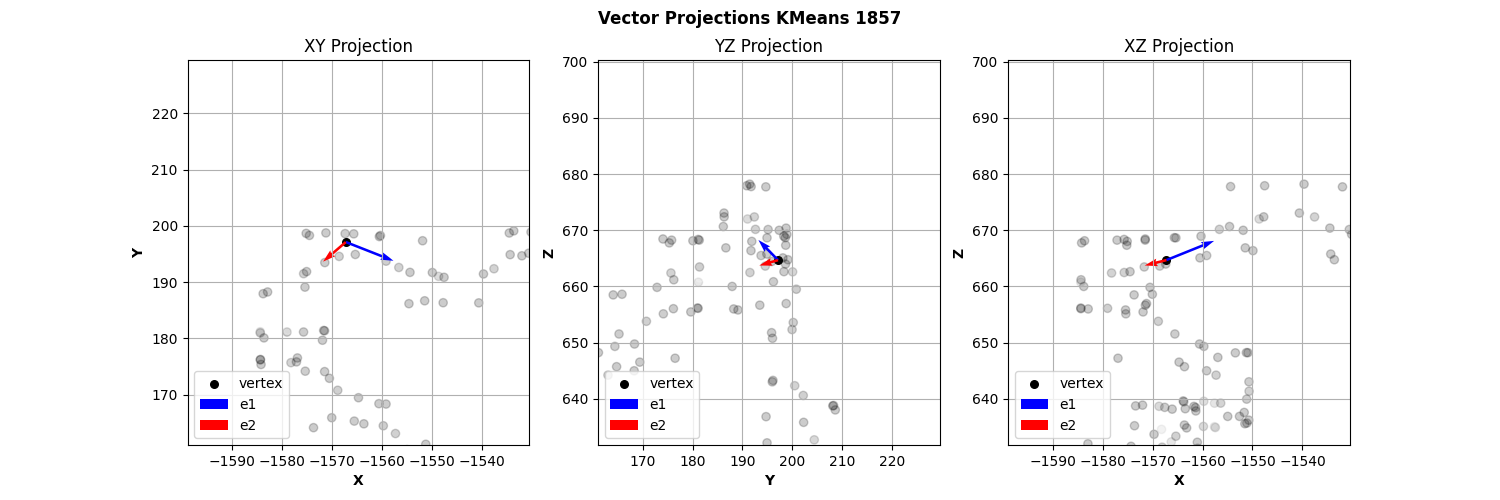

Processing event 1859...
1: 317
2: 317
3: 317
4: 317
Running grouping again new mean sigma is: 4.248736314944995
Running grouping again new mean sigma is: 8.49747262988999
5: 317
6: 55


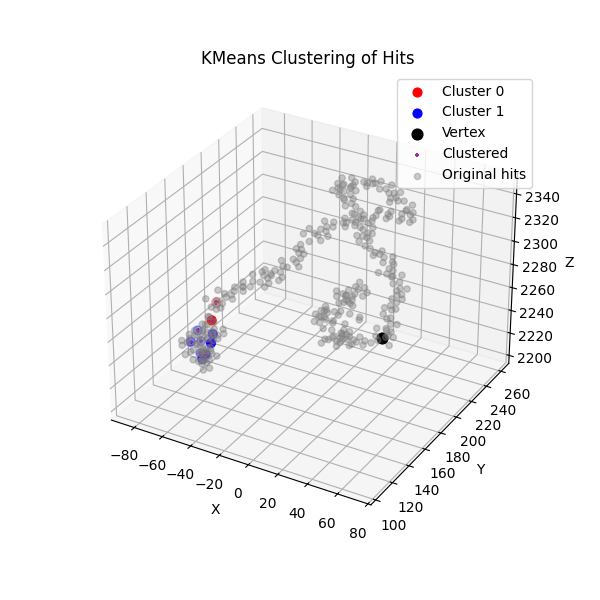

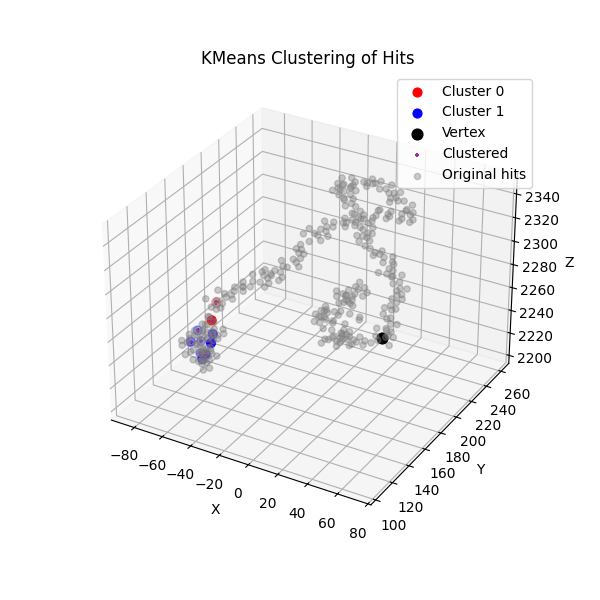

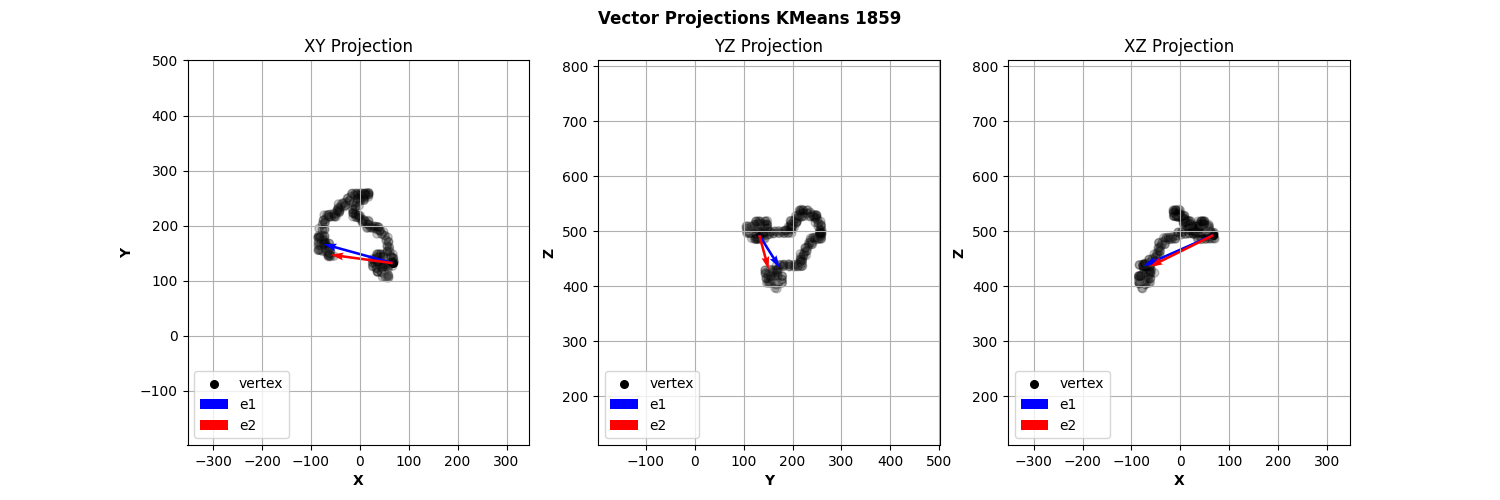

Processing event 1860...
1: 227
2: 227
3: 227
4: 227
Running grouping again new mean sigma is: 3.0
Running grouping again new mean sigma is: 6.0
Running grouping again new mean sigma is: 12.0
5: 227
6: 82


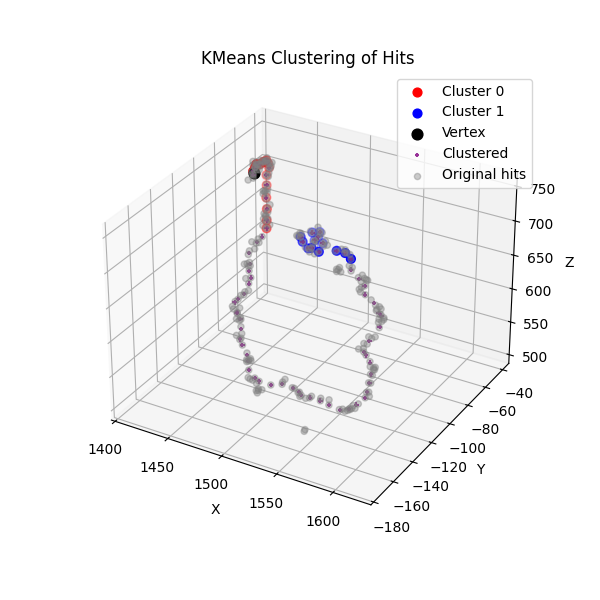

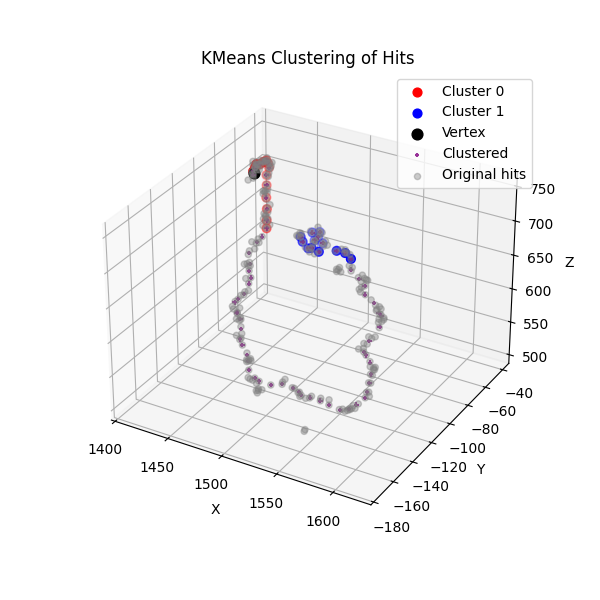

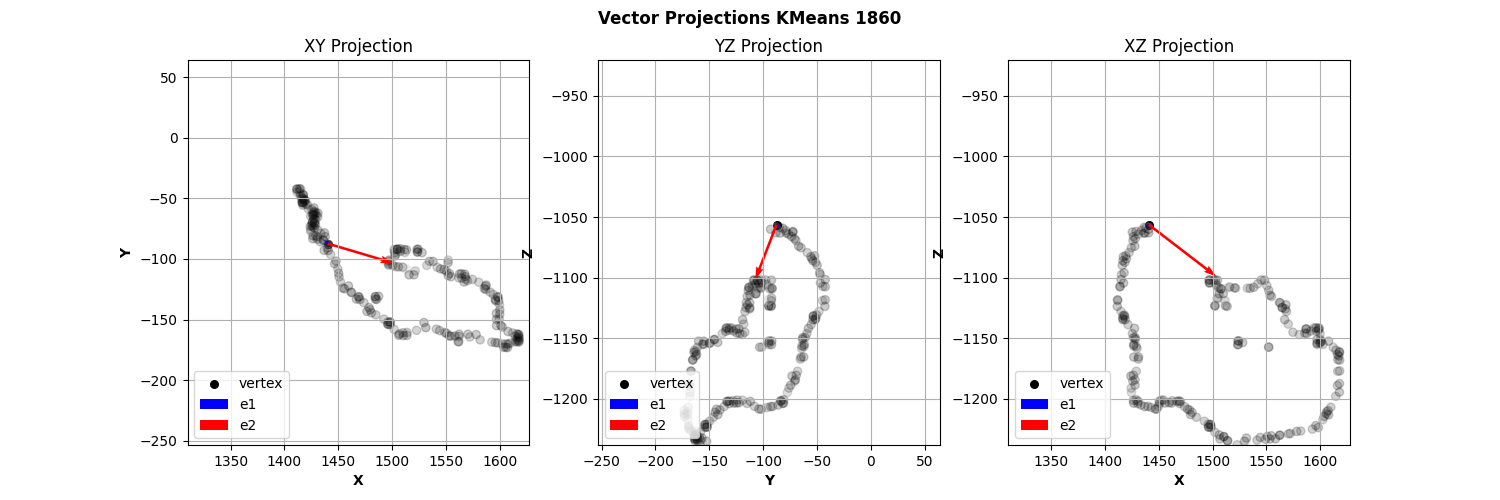

In [43]:
#testing...

file = "/home/rei/NEXT/vertex_ML/diffused_data/0nubb/5bar/5percent/ATPC_0nubb_5bar_Efilt_5.0percent_smear_20_4.h5"
hits_df = pd.read_hdf(file, "MC/hits")
parts_df = pd.read_hdf(file, "MC/particles")
pressure= 5
diffusion = "5percent"
event_ids = hits_df["event_id"].unique()
num_events = 10
count  = 0
for eid in event_ids:
    if count > num_events:
        break
    print(f"Processing event {eid}...")
    project_vectors_kmeans(file, eid, pressure, diffusion)
    count+=1

In [14]:
z_shift = get_zshift(5)
PlotEvent3D(111, file, "", 1851, part, z_shift)

NameError: name 'part' is not defined

In [ ]:
#Get angles from vectors

def get_angles(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return theta, phi

In [ ]:
#Cosine of angle between 2 vectors

def cos12_fun(theta1, phi1, theta2, phi2): #cos12 = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
    x = np.sin(theta1)*np.cos(phi1) * np.sin(theta2)*np.cos(phi2)
    y = np.sin(theta1)*np.sin(phi1) * np.sin(theta2)*np.sin(phi2)
    z = np.cos(theta1) * np.cos(theta2)
    return x+y+z

In [ ]:
import json
import pandas as pd
import numpy as np

def get_angle_data(json_file, num_events):
    with open(json_file, "r") as f:
        data = json.load(f)

    # Keep event_id along with event_data
    data_list = list(data.items())[:num_events]

    # Collect unique h5 files from selected events
    unique_h5_files = set(ev["path"] for _, ev in data_list)
    h5_data = {h5: pd.read_hdf(h5, "MC/hits") for h5 in unique_h5_files}

    total_event_data = []

    for event_id, event_data in data_list:
        h5_path = event_data["path"]
        event_type = event_data["type"]
        pressure = int(event_data["pressure"])
        diffusion = event_data["diffusion"]
        diffusion = str(diffusion)+"percent"
        vertex = np.array([event_data["x"], event_data["y"], event_data["z"]])

        # Access the preloaded hits DataFrame
        hits_df = h5_data[h5_path]


        node_centers_df = get_node_centers_df(hits_df, event_id, pressure, diffusion)
        if node_centers_df.empty:
            continue  # skip this event
        vectors = get_e_vectors(node_centers_df, vertex)
        if len(vectors)<2:
            continue
        v1 = vectors[0][1]
        v2 = vectors[1][1]

        theta1, phi1 = get_angles(v1[0], v1[1], v1[2])
        theta2, phi2 = get_angles(v2[0], v2[1], v2[2])
        cos12 = cos12_fun(theta1, phi1, theta2, phi2)
        cos12 = float(cos12)

        float_diffusion = re.search(r'\d+(\.\d+)?', diffusion)
        float_diffusion = float(float_diffusion.group())
        current_event_data = {
            "event_id": event_id,
            "h5_path": h5_path,
            "event_type": event_type,
            "pressure": pressure,
            "diffusion": float_diffusion,
            "vertex": vertex,
            "cos12": cos12
        }

        project_vectors_kmeans(h5_path, event_id, node_centers_df, vertex)

        total_event_data.append(current_event_data)
    total_event_data_df = pd.DataFrame(total_event_data)
    

    return total_event_data_df


In [ ]:
pd.options.mode.chained_assignment = None
json_file = "/home/rei/NEXT/vertex_ML/events_with_true_vertex_0nubb.json"
total_event_data = get_angle_data(json_file, 5)
total_event_data.head()

Text(0, 0.5, 'Events')

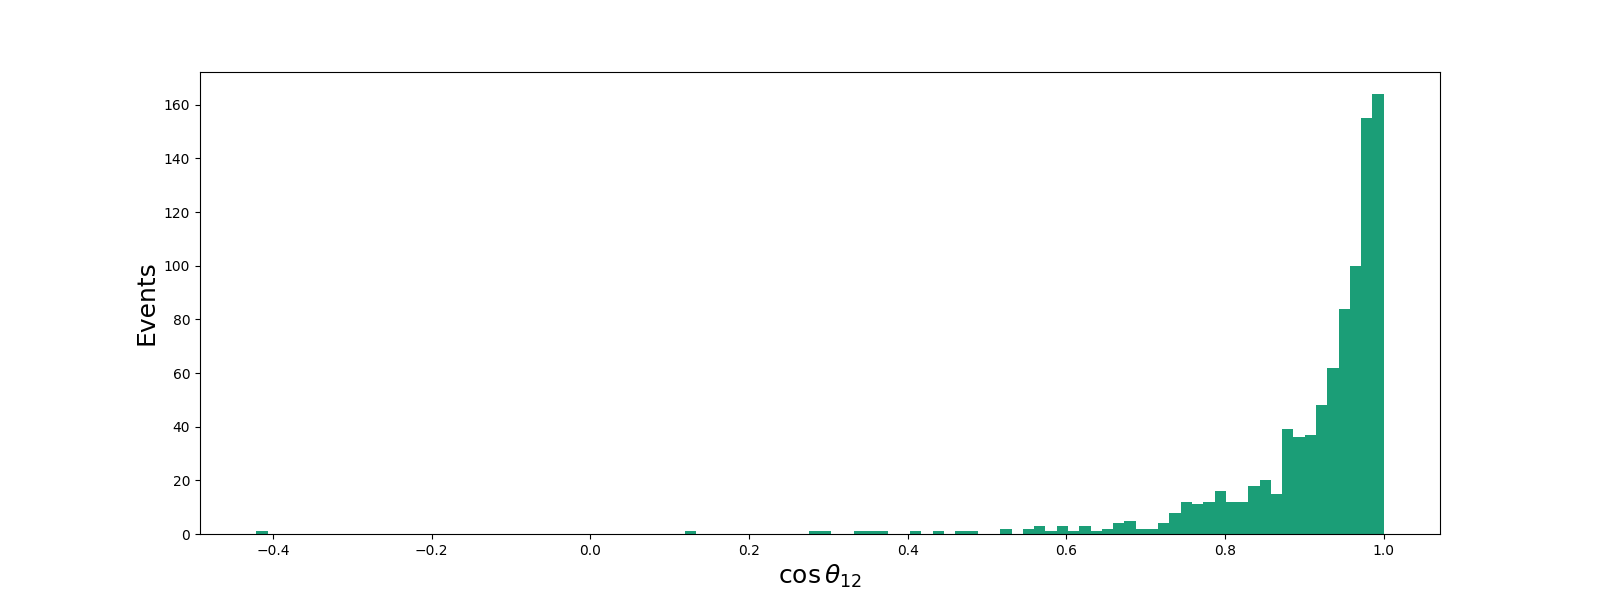

In [233]:
fig = plt.figure(figsize=(16,6))
counts_costheta12, bins_costheta12, patches = plt.hist(total_event_data["cos12"], bins=100)
plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
plt.ylabel('Events', fontsize=18)

In [236]:
#angular asymmetry factor

def get_asymmetry_factor(event_type, pressure, diffusion):

    theta_greater = 0
    theta_less = 0
    
    data_used = total_event_data[total_event_data["pressure"].isin(pressure) &
        total_event_data["event_type"].isin(event_type) &
        total_event_data["diffusion"].isin(diffusion)]
    #print("Number of rows after filtering:", len(data_used))
    #print("Unique pressures in data_used:", data_used["pressure"].unique())
    #print("Unique event types in data_used:", data_used["event_type"].unique())
    #print("Unique diffusions in data_used:", data_used["diffusion"].unique())


    for _, row in data_used.iterrows():
        theta = row["cos12"]
        if theta < 0:
            theta_greater += 1
        if theta > 0:
            theta_less +=1

    print(f"Theta greater than pi/2: {theta_greater}")
    print(f"Theta less than pi/2: {theta_less}")

    angular_asymmetry_factor = (theta_greater - theta_less)/(theta_greater + theta_less)

    return angular_asymmetry_factor
            
    

In [237]:
event_type= ["0nubb"]
pressure = [1, 5]
diffusion = [0.05, 0.1, 0.25,5]
total_event_data["diffusion"] = total_event_data["diffusion"].astype(float)

asymmetry_factor_0nubb = get_asymmetry_factor(event_type, pressure, diffusion)

#event_type = ["leptoquark"]

#asymetry_factor_leptoquark = get_asymmetry_factor(event_type, pressure, diffusion)

print(f"Angular asymmetry factor for 0nubb events: {asymmetry_factor_0nubb}")
#print(f"Angular asymmetry factor for leptoquark events: {asymmetry_factor_leptoquark}")

Theta greater than pi/2: 1
Theta less than pi/2: 906
Angular asymmetry factor for 0nubb events: -0.9977949283351709
